# Init

In [1]:
import pandas as pd
import numpy as np
import pyterrier as pt
import os
import json
import time

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
# dataset = pd.read_csv("./data/docs.tsv", sep="\t")
dataset = pd.read_csv("./data/docsWithKw.csv")
dataset["docno"] = dataset["docno"].astype("str")
dataset = dataset.rename(columns={
  "Title": "title",
  "URL": "url",
  "Area": "area",
  "Applicability": "applicability",
  "Owner": "owner"
})
features = ["title", "text", "area", "applicability", "owner", "kwList"]
datasetDict = dataset[["docno", *features]].to_dict(orient="records")
path = "./data/mm"

if not os.path.exists(os.path.join(path, "data.properties")):
    indexer = pt.IterDictIndexer(
        path,
        overwrite = True,
        blocks=True,
        meta={"docno": 20, "text": 4096, "title": 128}
    )
    indexRef = indexer.index(datasetDict, fields=features)
else:
    indexRef = pt.IndexRef.of(os.path.join(path, "data.properties"))

index = pt.IndexFactory.of(indexRef)

In [4]:
print(index.getCollectionStatistics().toString())

Number of documents: 4922
Number of terms: 52651
Number of postings: 1184448
Number of fields: 6
Number of tokens: 3250722
Field names: [title, text, area, applicability, owner, kwList]
Positions:   true



In [5]:
br = pt.BatchRetrieve(index, wmodel="BM25")
qe = pt.rewrite.Bo1QueryExpansion(index)
sdm = pt.rewrite.SDM()

In [6]:
qrel = pd.read_csv("./data/rel.csv")
qrel["relevance"] = qrel["rel"].astype("int64")
# qrel["score"] = qrel["relevance"]
qrel["label"] = qrel["relevance"]
qrel["docno"] = qrel["docno"].astype(str)

In [7]:
topics = qrel[["query"]].groupby("query").first().reset_index()
topics["qid"] = topics.index.astype(str)
topics = topics[["qid", "query"]]

In [8]:
qrel = pd.merge(qrel, topics, how="inner", on="query")

# Train

In [9]:
SEED = 42

from sklearn.model_selection import train_test_split

trainValidTopics, testTopics = train_test_split(topics, test_size=10, random_state=SEED)
trainTopics, validTopics =  train_test_split(trainValidTopics, test_size=5, random_state=SEED)

In [ ]:
from keybert import KeyBERT
kwModel = KeyBERT()

In [ ]:
docs = pd.read_csv("./data/docs.tsv", sep="\t")
kws = kwModel.extract_keywords(
  docs["text"],
  keyphrase_ngram_range=(1, 1),
  stop_words="english",
  use_mmr=True,
  diversity=0.4
)
kws = [dict(filter(lambda x: x[1] > 0.2, kw)) for kw in kws]
docs["kw"] = kws

3157    {'adverse': 0.4683, 'medications': 0.3927, 'al...
Name: kw, dtype: object

In [ ]:
docs["kwList"] = docs["kw"].map(lambda x: " ".join([kw for kw in x]))
docs["kwList"] = docs["kwList"].replace("", "empty")
docs.to_csv("./data/docsWithKw.csv")

In [ ]:
docs = pd.read_csv("./data/docsWithKw.csv")
docs["kw"] = docs["kw"].apply(lambda x: eval(x))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def normalize(arr):
    s = sum(arr)
    if (s != 0):
        return [x / s for x in arr]
    else:
        return arr
def getIndex(tf, tokens):
    return normalize([tf[x] if x in tf else 0 for x in tokens])
def simOfTags(query, docno):
    queryKw = dict(kwModel.extract_keywords(query))
    kw = docs[docs["docno"] == int(docno)]["kw"].values[0]
    tokens = list(set([*[x[0] for x in queryKw.items()], *[x[0] for x in kw.items()]]))
    tokens.sort()
    v1 = getIndex(queryKw, tokens)
    v2 = getIndex(kw, tokens)
    sim = cosine_similarity([v1], [v2])
    return sim[0][0]

In [10]:
br = pt.BatchRetrieve(index, wmodel="BM25")
features = br >> qe >> br >> pt.text.get_text(index, ["text", "title"]) >> (
    pt.transformer.IdentityTransformer()
    **
    (sdm >> br)
    **
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
    **
    (pt.apply.query(lambda row: "guideline") >> br)
    **
    (pt.apply.query(lambda row: "policy") >> br)
#     **
#     (pt.apply.doc_score(lambda row: simOfTags(row["query_0"], row["docno"])))
)

In [11]:
import fastrank

trainRequest = fastrank.TrainRequest.coordinate_ascent()

params = trainRequest.params
params.init_random = True
params.normalize = True
params.seed = 1234567

caPipe = features >> pt.ltr.apply_learned_model(trainRequest, form="fastrank")

%time caPipe.fit(trainTopics, qrel)

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
   3|0         

In [ ]:
pt.Experiment(
    [br, pt.BatchRetrieve(index, wmodel=randomScore), rfPipe, lmartPipe, caPipe],
    testTopics,
    qrel,
    names=["BM25", "Random", "RandomForest", "LMART", "CoordinateAscent"],
    eval_metrics=["map", "ndcg", "ndcg_cut.10", "P.10", "mrt"]
)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.1s finished
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of '

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1


,name,map,ndcg,ndcg_cut.10,P.10,mrt
0,BM25,0.868709,0.911058,0.815990,0.99,171.595038
1,Random,0.237678,0.548706,0.254955,0.39,472.122247
2,RandomForest,0.682146,0.814552,0.599562,0.78,1352.648271
3,LMART,0.805737,0.895974,0.793113,0.95,1318.734030
4,CoordinateAscent,0.996414,0.943313,0.841814,1.00,1328.548500


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=16)

rfPipe = features >> pt.ltr.apply_learned_model(rf)

%time rfPipe.fit(trainTopics, qrel)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    1.7s


CPU times: user 1min 29s, sys: 526 ms, total: 1min 30s
Wall time: 39 s


[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    3.8s finished


In [ ]:
import lightgbm as lgb

lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmartPipe = features >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmartPipe.fit(trainTopics, qrel, validTopics, qrel)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 25721,

/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/sklearn.py:641: UserWarning: Found 'ndcg_eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/home/remisiki/.local/lib/python3.10/site-packages/lightgbm/engine.py:143: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [ ]:
def randomScore(keyFreq, posting, entryStats, collStats):
    return (
        np.random.random()
    )

# Server

In [12]:
dataset["kw"] = dataset["kw"].map(lambda x: eval(x))

In [13]:
def search(query):
  start = time.time()
  if (query.strip() == ""):
    return {
        "data": [],
        "time": (time.time() - start),
        "count": 0
    }
  else:
    d = caPipe.search(query).drop(columns=["title", "text"])
    d = d.merge(dataset, on="docno")
    d = d[["score", "title", "text", "url", "area", "applicability", "owner", "docno", "kw"]]
    # d = d[d["score"] > 1.25]
    d = d[:50]
    data = json.loads(d.to_json(orient="records"))
    return {
        "data": data,
        "time": (time.time() - start),
        "count": len(data)
    }

In [ ]:
from flask import Flask
from flask import request
app = Flask(__name__)

@app.route('/api', methods=["POST"])
def home():
  query = request.form["query"]
  return json.dumps({
      "error": False,
      **search(query)
  })
app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000 (Press CTRL+C to quit)


# Stats

In [ ]:
qrel["qc"] = qrel["query"].str.split(" ").apply(lambda x: len(x))

In [ ]:
qrel[["qid", "qc"]].groupby("qid").first().value_counts()

qc
2     30
1      8
4      2
3      1
dtype: int64

In [ ]:
import seaborn as sns
qrel = pd.read_csv("./data/rel.csv")

In [ ]:
qrel[["rel"]].describe()

,rel
count,2050.000000
mean,3.012683
std,1.478605
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


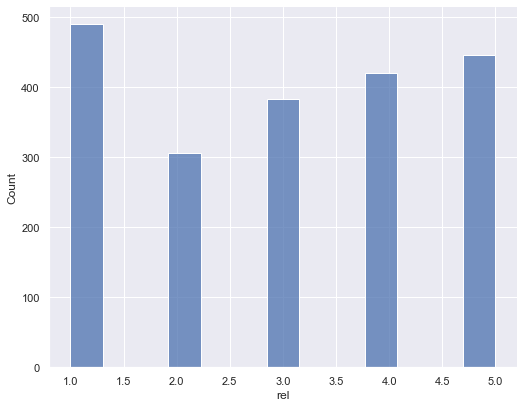

In [ ]:
fig = sns.displot(qrel["rel"])
fig.fig.set_size_inches(8, 6)
plt.savefig("rel.png")